we only need to normalize when there is some bandit events. For pure organic, it doesn't really make sense since we consider each row independently != if we look at a log where a row is a reco then we need to divide by the length of the organic session, which is stochastic (independent of our reco)

actually we need this because otherwise when we apply the discount it won't work. At least we need it for the MDP reward
--> for the organic user : we should divide by the number of time each action a is viewed by user u ?

Idea : click => "only one chance to click"

In [1]:
import gym, recogym
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import pandas as pd
import pickle as pkl
pd.options.mode.chained_assignment = None 
# from inspect import getsource
from recogym.evaluate_agent_sale import verify_agents_sale, plot_verify_agents_sale, plot_CR_CTR
from tqdm import tqdm

# env_1_sale_args is a dictionary of default parameters (i.e. number of products)
from recogym import env_1_sale_args, Configuration
from recogym.envs.utils_sale import (share_states, share_sale, env_infos, count_sales_first_session, 
                                     get_beta_confidence_interval, share_user_with_sale, share_clicks_with_sale)
# You can overwrite environment arguments here:
env_1_sale_args['random_seed'] = 42

# Initialize the gym for the first time by calling .make() and .init_gym()
env = gym.make('reco-gym-sale-v1')
env.init_gym(env_1_sale_args)

# .reset() env before each episode (one episode per user).
env.reset()
done = False

env_1_sale_args['num_products'] = 10
num_products = env_1_sale_args['num_products']
env_1_sale_args['number_of_flips'] = 5

# You can overwrite environment arguments here:
env_1_sale_args['random_seed'] = 42
env_1_sale_args['mu_sale'] = False
# env_1_sale_args['sigma_mu_sale'] = env_1_sale_args['sigma_mu_organic']/4


# Initialize the gym 
env = gym.make('reco-gym-sale-v1')
env.init_gym(env_1_sale_args)


1.966042202395077
mu sale [-0.99379029 -3.12128904 -3.9968082  -0.13101334  1.12695637  0.82779815
 -4.48369477 -2.89367933 -0.97225191  0.96059318]
mu sale [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [36]:
nb_flips = env_1_sale_args['number_of_flips']

## Build targets

In [37]:
## Clicks
from recogym.agents.sale_agent import ClickRewardProvider
Click_rewards = ClickRewardProvider()

## MDP
from recogym.agents.sale_agent import MDPRewardProvider, PostDisplayRewardProvider,DifferenceRewardProvider,NoclickRewardProdivder
# doesn't take into account the length of the observation
MDP_rewards = MDPRewardProvider()
MDP_rewards_all = MDPRewardProvider(clicks_only=False)
# take into account length of the observation
MDP_rewards_time = MDPRewardProvider(clicks_only=True, organic_only=False, normalize = True)
MDP_rewards_all_time = MDPRewardProvider(clicks_only=False, organic_only=False, normalize = True)
MDP_rewards_pureorganic = MDPRewardProvider(clicks_only=False, organic_only=True)
PostDisplay_rewards = PostDisplayRewardProvider()
Noclick_rewards_provider = NoclickRewardProdivder()
Noclick_rewards_provider_time = NoclickRewardProdivder(normalize = True)
# Diff_rewards = DifferenceRewardProvider(MDP_rewards_all_time,MDP_rewards_pureorganic,normalize = False)
# Diff_rewards_norm = DifferenceRewardProvider(MDP_rewards_all_time,MDP_rewards_pureorganic,normalize = True)

rewards = {'click':Click_rewards,
          'MDP':MDP_rewards,
          'MDP_all':MDP_rewards_all,
          'MDP_time':MDP_rewards_time,
          'MDP_all_time':MDP_rewards_all_time,
          'MDP_pureorganic':MDP_rewards_pureorganic,
          'PostDisplay':PostDisplay_rewards}

## Build features

In [38]:
from recogym.agents.sale_agent import CountViewsClicksFeatureProvider, CountViewsFeatureProvider, ShareViewsClicksFeatureProvider, ShareViewsFeatureProvider
vc_feature = CountViewsClicksFeatureProvider(env.config)
v_feature = CountViewsFeatureProvider(env.config)
vc_share_feature = ShareViewsClicksFeatureProvider(env.config)
v_share_feature = ShareViewsFeatureProvider(env.config)

features = {'vc':vc_feature,
           'v':v_feature,
           'vc_share':vc_share_feature,
           'v_share':v_share_feature}

## Train baseline agents

In [39]:
# Choose number of users for training and AB test
env_1_sale_args['num_users'] = 20000
env_1_sale_args['num_users_AB'] = 1000
num_users = env_1_sale_args['num_users']
num_users_AB = env_1_sale_args['num_users_AB']

# Choose features
feature_name = 'v_share'
feature = features[feature_name]

In [40]:
from recogym.agents.sale_agent import build_train_data
from recogym.agents.sale_agent import SaleLikelihoodAgent, SaleProductLikelihoodAgent
from recogym.agents.sale_agent import train_agents, train_timeagents

agents={}
logs={}

############## Random agent
from recogym.agents import RandomAgent, random_args
random_agent = RandomAgent(Configuration(random_args))
name_agent = 'rand'+str(nb_flips)
agents[name_agent] = random_agent
try:
    data = pkl.load(open(str('data\data'+str(num_users)+name_agent+'.pkl'),'rb'))
except :
    data = deepcopy(env).generate_logs(num_users)
    pkl.dump(data,open(str('data\data'+str(num_users)+name_agent+'.pkl'),'wb'))
logs[name_agent] = data
    
# ############## Organic agent
# from recogym.agents import OrganicUserEventCounterAgent, organic_user_count_args
# organic_counter_agent = OrganicUserEventCounterAgent(Configuration({**organic_user_count_args,
#                                                                     **env_1_sale_args,
#                                                                     'select_randomly': True}))
# name_agent = 'organic'+str(nb_flips)
# agents[name_agent] = organic_counter_agent
# try:
#     data = pkl.load(open(str('data\data'+str(num_users)+name_agent+'.pkl'),'rb'))
# except :
#     data = deepcopy(env).generate_logs(num_users,agent=organic_counter_agent)
#     pkl.dump(data,open(str('data\data'+str(num_users)+name_agent+'.pkl'),'wb'))
# logs[name_agent] = data

# ############## Likelihood click kronecker
# name_agent = "likclickkron"
# try :
#     data = pkl.load(open(str('data\data'+str(num_users)+name_agent+'.pkl'),'rb'))
# except:
#     likelihood_logreg_click = SaleLikelihoodAgent(feature, Click_rewards,kronecker_features=True)
#     likelihood_logreg_click.train(data)
#     agents[name_agent] = likelihood_logreg_click
#     data = deepcopy(env).generate_logs(num_users, agent=likelihood_logreg_click)
#     pkl.dump(data,open(str('data\data'+str(num_users)+name_agent+'.pkl'),'wb'))
# logs[name_agent] = data

### Agents with a notion of time

In [7]:
from datetime import datetime
datetime.now()

datetime.datetime(2020, 8, 19, 14, 47, 34, 733791)

### Random

In [8]:
res_dict_time = {}

#### Discounted models only with noclick train

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 5000/5000 [03:07<00:00, 26.72it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████| 5000/5000 [3:50:56<00:00,  2.77s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████| 5000/5000 [3:51:58<00:00,  2.78s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████| 5000/5000 [3:52:09<00:00,  2.79s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████| 5000/5000 [3:21:48<00:00,  2.42s/it]


2020-08-21 08:11:14.033171


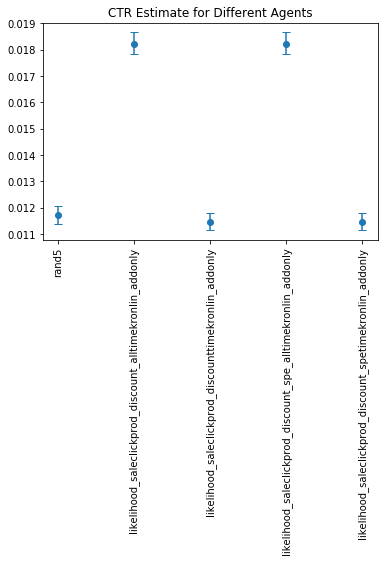

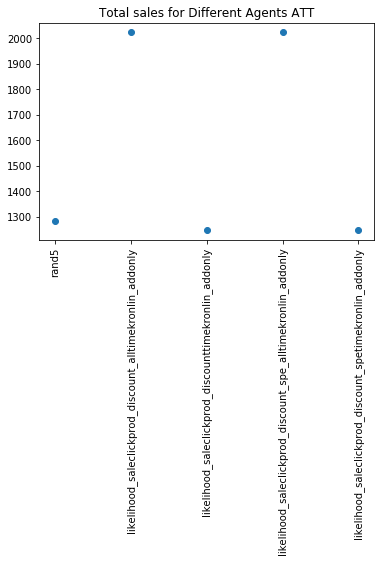

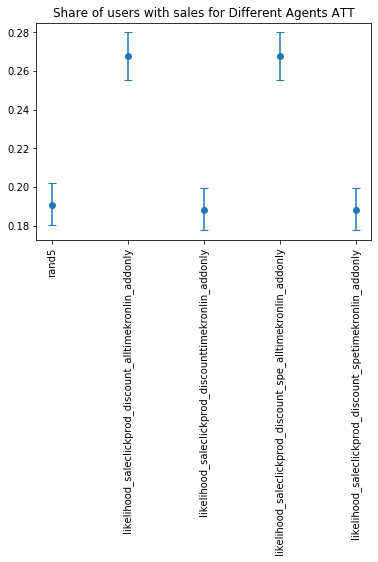

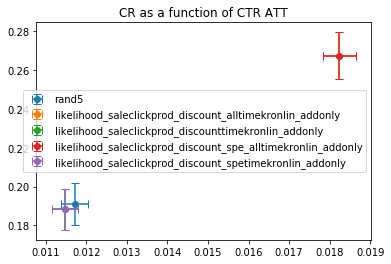

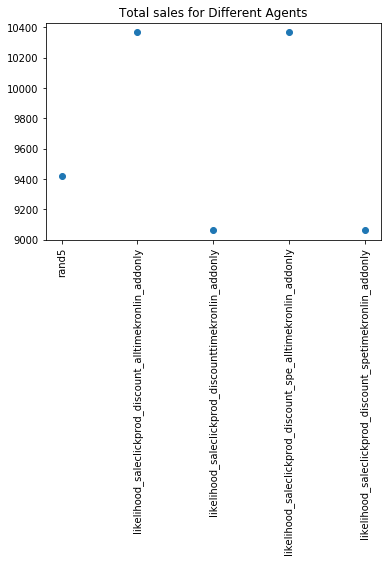

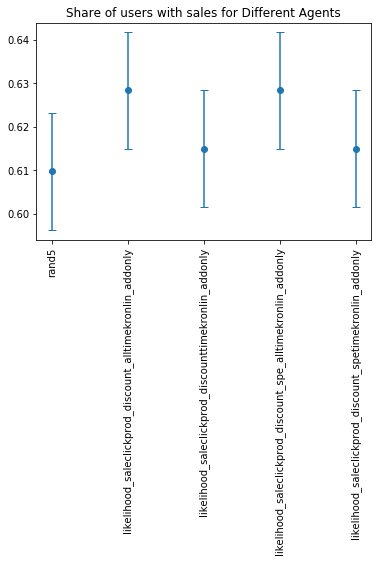

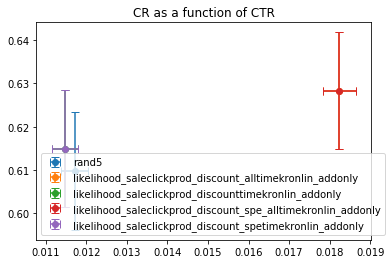

In [13]:
name_extension = 'timekronlin'+str(nb_flips)+'_addonly'
num_users_AB = 5000
name_logging = 'rand'+str(nb_flips)
data = logs[name_logging]
# try :


info, save_agents = pkl.load(open(str('data/timeagents10000rand5v_sharetimekronlin_addonly.pkl'),'rb'))
# info, save_agents = pkl.load(open(str('data/timeagents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'rb'))
# except :
#     info, save_agents = train_timeagents(name_logging,logs,feature_name,features, num_users=num_users,
#                                          kronecker_features=True,linear_reg=True,additional_models_only=True)

# A/B test
env.reset()
res=verify_agents_sale(
    env,
    number_of_users=num_users_AB,
    agents={
        **agents, 
        **save_agents},
    name = name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension
)

# save result
# pkl.dump([res, env_1_sale_args, info, save_agents],
#          open("data/res_"+name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension+".pkl","wb"))
res_dict_time[name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension] = res

print(datetime.now())

# plot result
plot_verify_agents_sale(res["CTR"], res["Tot sales ATT"], res['Share user with sale ATT'], 
                        res["Tot sales"], res['Share user with sale'])
None


#### Discounted models only with noclick train and weights

Kronecker features
Linear reg
Weights
addition models only
Non specific discount noclick
Specific discount noclick


Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 5000/5000 [02:27<00:00, 33.87it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████| 5000/5000 [3:21:11<00:00,  2.41s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████| 5000/5000 [3:22:28<00:00,  2.43s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████| 5000/5000 [3:38:01<00:00,  2.62s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████| 5000/5000 [4:00:49<00:00,  2.89s/it]


2020-08-22 01:29:24.005034


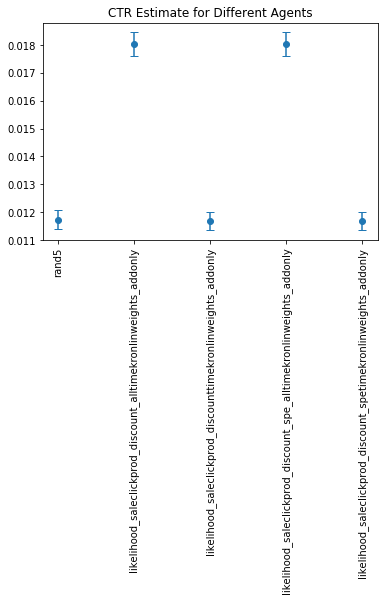

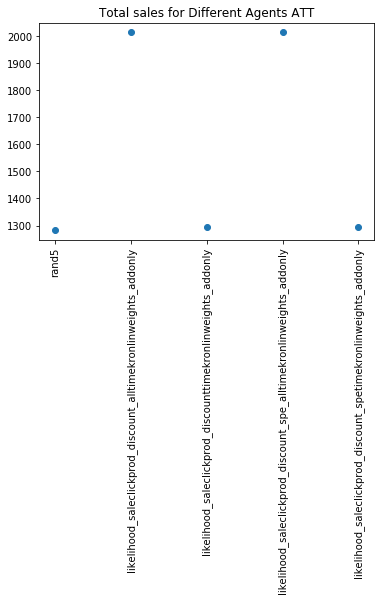

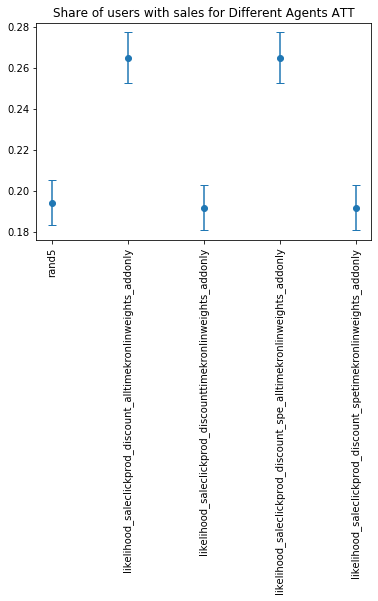

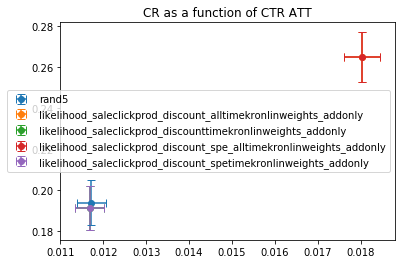

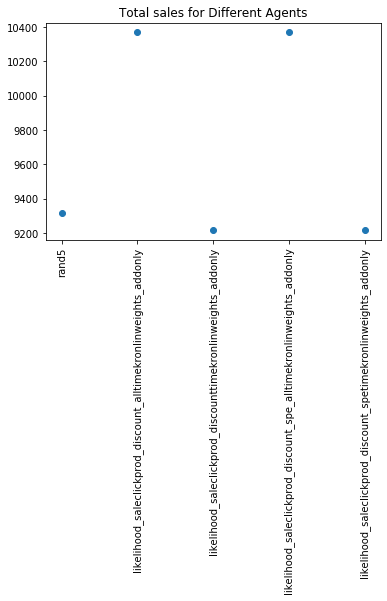

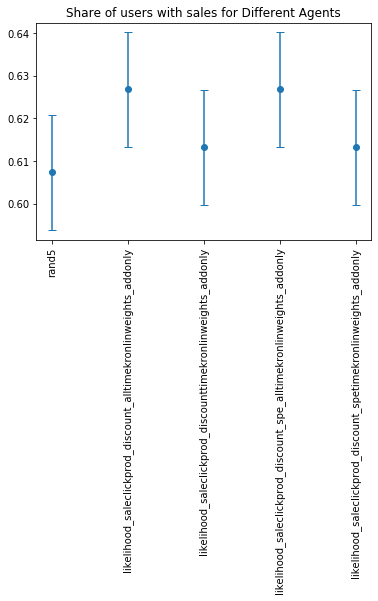

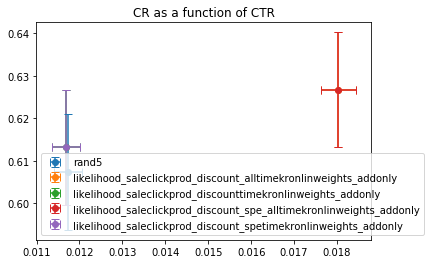

In [14]:
name_extension = 'timekronweights'+str(nb_flips)+'_addonly'
num_users_AB = 5000
name_logging = 'rand'+str(nb_flips)
data = logs[name_logging]
try :
    info, save_agents = pkl.load(open(str('data/timeagents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'rb'))
except :
    info, save_agents = train_timeagents(name_logging,logs,feature_name,features, num_users=num_users,
                                         kronecker_features=True,linear_reg=True,weights=True,additional_models_only=True)

# A/B test
env.reset()
res=verify_agents_sale(
    env,
    number_of_users=num_users_AB,
    agents={
        **agents, 
        **save_agents},
    name = name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension
)

# save result
# pkl.dump([res, env_1_sale_args, info, save_agents],
#          open("data/res_"+name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension+".pkl","wb"))
res_dict_time[name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension] = res

print(datetime.now())

# plot result
plot_verify_agents_sale(res["CTR"], res["Tot sales ATT"], res['Share user with sale ATT'], 
                        res["Tot sales"], res['Share user with sale'])
None


#### all models, no weights

Kronecker features
Linear reg
Click agent
No discount
Non specific discount
Specific discount


Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████| 10000/10000 [05:01<00:00, 33.20it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████| 10000/10000 [4:28:29<00:00,  1.61s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████| 10000/10000 [5:39:38<00:00,  2.04s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████| 10000/10000 [5:53:22<00:00,  2.12s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████| 10000/10000 [6:49:53<00:00,  2.46s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████| 10000/10000 [6:54:16<00:00,  2.49s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████████████████████████

2020-08-27 03:24:02.919130


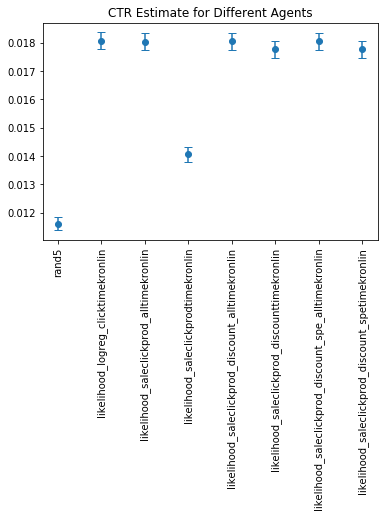

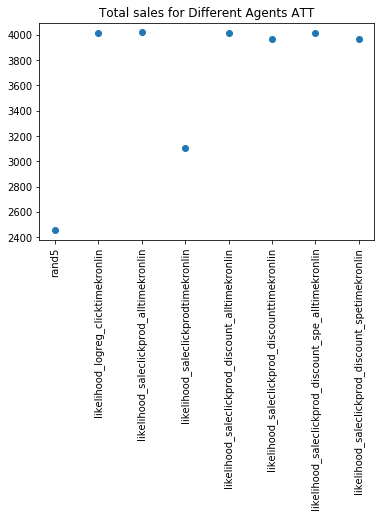

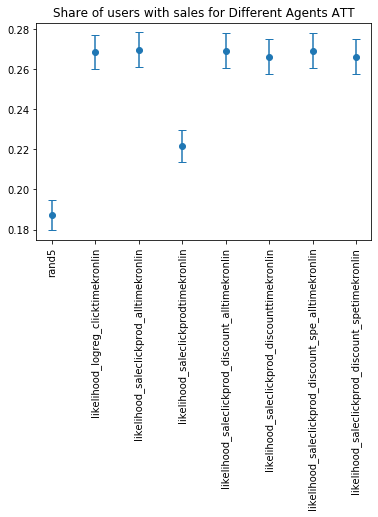

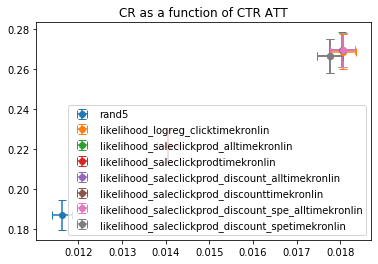

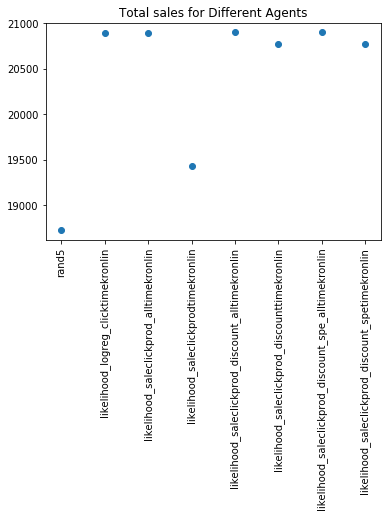

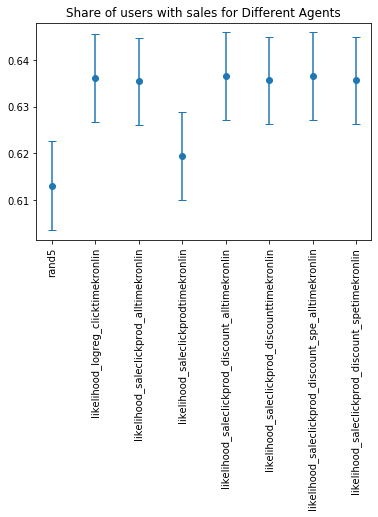

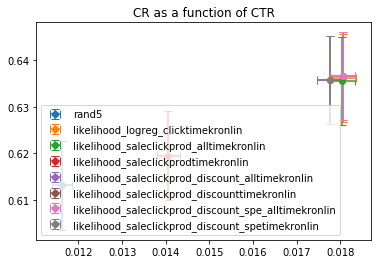

In [42]:
name_extension = 'timekronlin'+str(nb_flips)
num_users_AB = 10000
name_logging = 'rand'+str(nb_flips)
data = logs[name_logging]
try :
    info, save_agents = pkl.load(open(str('data/timeagents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'rb'))
except :
    info, save_agents = train_timeagents(name_logging,logs,feature_name,features, num_users=num_users,
                                         kronecker_features=True,linear_reg=True)

# A/B test
env.reset()
res=verify_agents_sale(
    env,
    number_of_users=num_users_AB,
    agents={
        **agents, 
        **save_agents},
    name = name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension
)

# save result
# pkl.dump([res, env_1_sale_args, info, save_agents],
#          open("data/res_"+name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension+".pkl","wb"))
res_dict_time[name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension] = res

print(datetime.now())

# plot result
plot_verify_agents_sale(res["CTR"], res["Tot sales ATT"], res['Share user with sale ATT'], 
                        res["Tot sales"], res['Share user with sale'])
None


In [61]:
k = list(res_dict_time.keys())[2]
display(res_dict_time[k]['Tot sales ATT'])
display(res_dict_time[k]['Share user with sale ATT'])
display(res_dict_time[k]['Tot sales'])
res_dict_time[k]['Share user with sale']

,Agent,TotSalesAtt
0,rand5,1269
1,likelihood_logreg_clicktimekronlin,2022
2,likelihood_saleclickprod_alltimekronlin,2009
3,likelihood_saleclickprodtimekronlin,1326
4,likelihood_saleclickprod_discount_alltimekronlin,2020
5,likelihood_saleclickprod_discounttimekronlin,1985
6,likelihood_saleclickprod_discount_spe_alltimek...,2020
7,likelihood_saleclickprod_discount_spetimekronlin,1985


,Agent,0.025,0.500,0.975
0,rand5,0.178392,0.189083,0.200092
1,likelihood_logreg_clicktimekronlin,0.254528,0.266662,0.279035
2,likelihood_saleclickprod_alltimekronlin,0.254922,0.267062,0.279441
3,likelihood_saleclickprodtimekronlin,0.185822,0.196681,0.207850
4,likelihood_saleclickprod_discount_alltimekronlin,0.255119,0.267262,0.279643
5,likelihood_saleclickprod_discounttimekronlin,0.250984,0.263063,0.275385
6,likelihood_saleclickprod_discount_spe_alltimek...,0.255119,0.267262,0.279643
7,likelihood_saleclickprod_discount_spetimekronlin,0.250984,0.263063,0.275385


,Agent,TotSales
0,rand5,9348
1,likelihood_logreg_clicktimekronlin,10369
2,likelihood_saleclickprod_alltimekronlin,10325
3,likelihood_saleclickprodtimekronlin,9292
4,likelihood_saleclickprod_discount_alltimekronlin,10353
5,likelihood_saleclickprod_discounttimekronlin,10323
6,likelihood_saleclickprod_discount_spe_alltimek...,10353
7,likelihood_saleclickprod_discount_spetimekronlin,10323


,Agent,0.025,0.500,0.975
0,rand5,0.593383,0.606971,0.620450
1,likelihood_logreg_clicktimekronlin,0.614910,0.628366,0.641690
2,likelihood_saleclickprod_alltimekronlin,0.615715,0.629166,0.642484
3,likelihood_saleclickprodtimekronlin,0.606658,0.620168,0.633555
4,likelihood_saleclickprod_discount_alltimekronlin,0.614709,0.628166,0.641492
5,likelihood_saleclickprod_discounttimekronlin,0.614507,0.627966,0.641293
6,likelihood_saleclickprod_discount_spe_alltimek...,0.614709,0.628166,0.641492
7,likelihood_saleclickprod_discount_spetimekronlin,0.614507,0.627966,0.641293


Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 5000/5000 [02:46<00:00, 30.02it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████| 5000/5000 [2:37:21<00:00,  1.89s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████| 5000/5000 [3:15:12<00:00,  2.34s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████| 5000/5000 [3:19:26<00:00,  2.39s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████| 5000/5000 [3:54:14<00:00,  2.81s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████| 5000/5000 [3:37:41<00:00,  2.61s/it]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████████████████████████

2020-08-24 20:36:01.972214


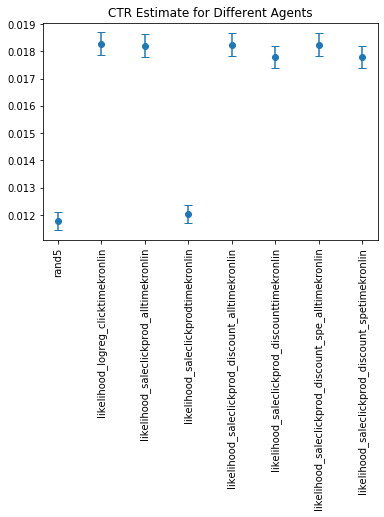

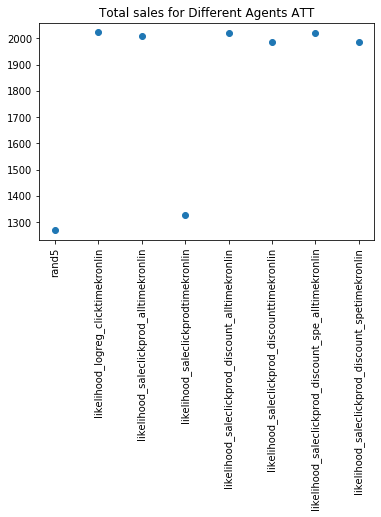

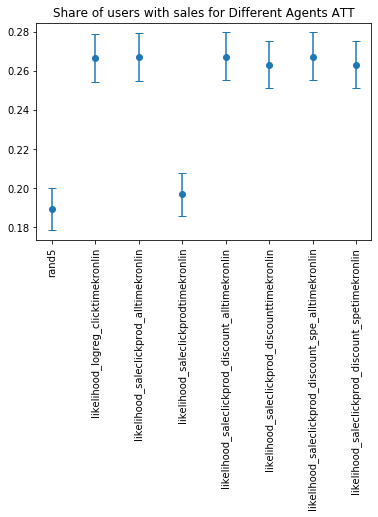

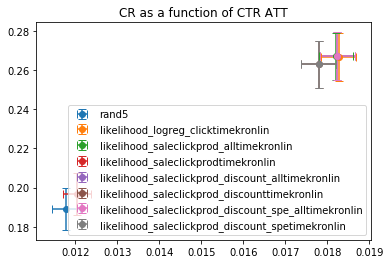

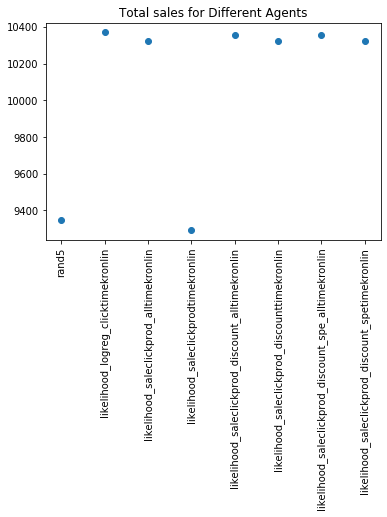

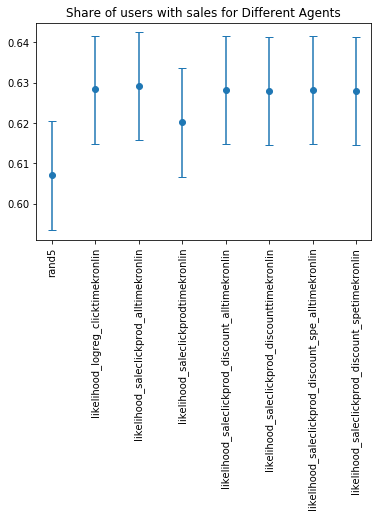

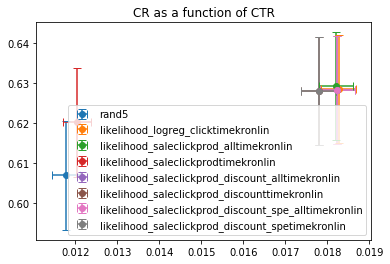

In [19]:
name_extension = 'timekronlin'+str(nb_flips)
num_users_AB = 5000
name_logging = 'rand'+str(nb_flips)
data = logs[name_logging]
# try :
#     info, save_agents = pkl.load(open(str('data/timeagents'+str(num_users)+name_logging+feature_name+name_extension+'.pkl'),'rb'))
info, save_agents = pkl.load(open(str('data/timeagents10000rand5v_sharetimekronlin.pkl'),'rb'))
# except :
#     info, save_agents = train_timeagents(name_logging,logs,feature_name,features, num_users=num_users,
#                                          kronecker_features=True,linear_reg=True)

# A/B test
env.reset()
res=verify_agents_sale(
    env,
    number_of_users=num_users_AB,
    agents={
        **agents, 
        **save_agents}
)

# save result
# pkl.dump([res, env_1_sale_args, info, save_agents],
#          open("data/res_"+name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension+".pkl","wb"))
res_dict_time[name_logging+str(num_users)+"_"+str(num_users_AB)+"_"+feature_name+name_extension] = res

print(datetime.now())

# plot result
plot_verify_agents_sale(res["CTR"], res["Tot sales ATT"], res['Share user with sale ATT'], 
                        res["Tot sales"], res['Share user with sale'])
None


# Time agents 10k/5k

In [39]:
list_keys = ["CTR","Tot sales ATT","Share user with sale ATT","Tot sales","Share user with sale"]

## No weights

In [47]:
k = 'res_likelihood_saleclickprod_discount_spetimekronlin'
res_noweights= pkl.load(open(str("data/"+k+".pkl"),"rb"))

k = 'res_rand510000_5000_v_sharetimekronlin5_addonlylikelihood_saleclickprod_discount_spetimekronlin_addonly'
res_noweights_add= pkl.load(open(str("data/"+k+".pkl"),"rb"))

for k in res_noweights.keys():
    if k in list_keys:
        res_noweights[k] = pd.concat([res_noweights[k],res_noweights_add[k]])
    else:
        res_noweights[k] = None

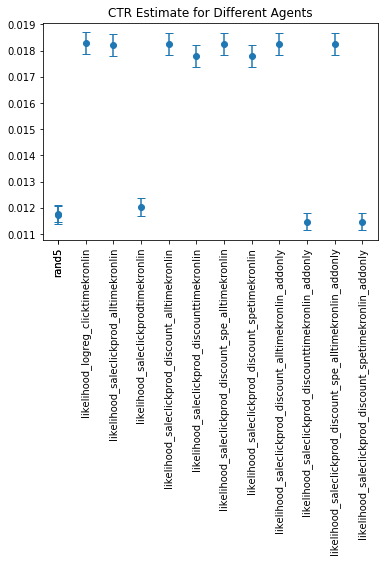

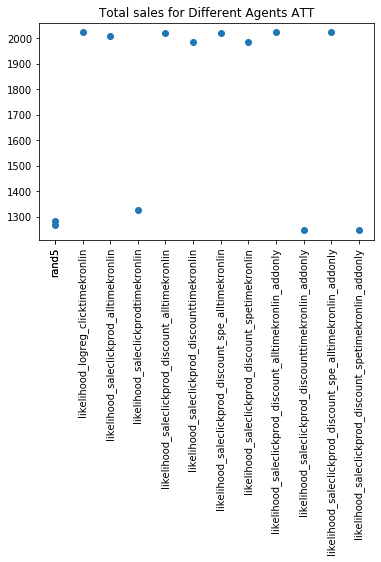

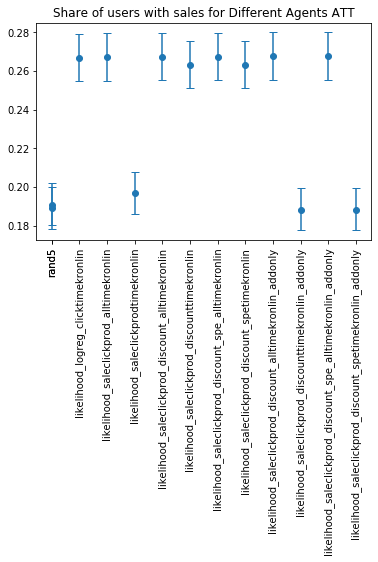

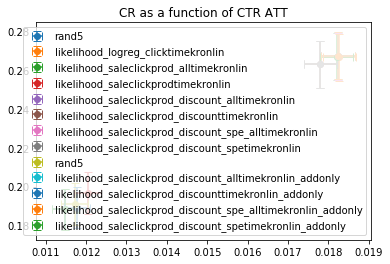

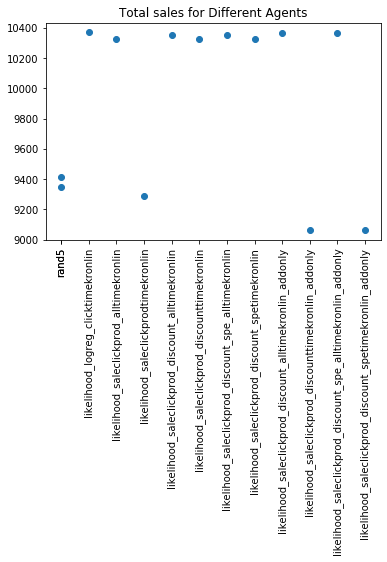

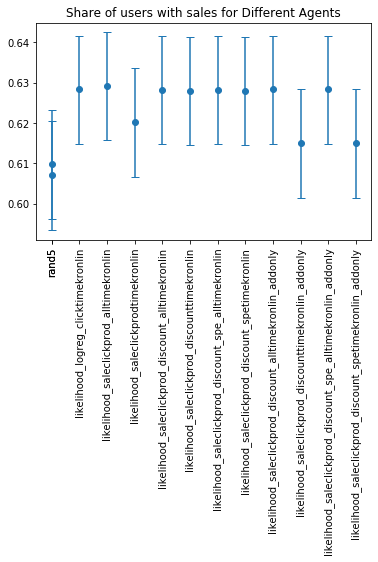

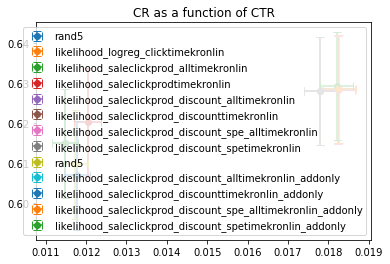

In [56]:
res = res_noweights
plot_verify_agents_sale(res["CTR"], res["Tot sales ATT"], res['Share user with sale ATT'], 
                        res["Tot sales"], res['Share user with sale'])
None

In [57]:
display(res["CTR"])
display(res["Tot sales ATT"])
display(res['Share user with sale ATT'])
display(res["Tot sales"])
display(res['Share user with sale'])

,Agent,0.025,0.500,0.975
0,rand5,0.011440,0.011774,0.012113
1,likelihood_logreg_clicktimekronlin,0.017861,0.018274,0.018693
2,likelihood_saleclickprod_alltimekronlin,0.017796,0.018208,0.018626
3,likelihood_saleclickprodtimekronlin,0.011702,0.012037,0.012378
4,likelihood_saleclickprod_discount_alltimekronlin,0.017831,0.018243,0.018662
5,likelihood_saleclickprod_discounttimekronlin,0.017387,0.017795,0.018209
6,likelihood_saleclickprod_discount_spe_alltimek...,0.017831,0.018243,0.018662
7,likelihood_saleclickprod_discount_spetimekronlin,0.017387,0.017795,0.018209
0,rand5,0.011388,0.011720,0.012058
1,likelihood_saleclickprod_discount_alltimekronl...,0.017827,0.018239,0.018658


,Agent,TotSalesAtt
0,rand5,1269
1,likelihood_logreg_clicktimekronlin,2022
2,likelihood_saleclickprod_alltimekronlin,2009
3,likelihood_saleclickprodtimekronlin,1326
4,likelihood_saleclickprod_discount_alltimekronlin,2020
5,likelihood_saleclickprod_discounttimekronlin,1985
6,likelihood_saleclickprod_discount_spe_alltimek...,2020
7,likelihood_saleclickprod_discount_spetimekronlin,1985
0,rand5,1283
1,likelihood_saleclickprod_discount_alltimekronl...,2022


,Agent,0.025,0.500,0.975
0,rand5,0.178392,0.189083,0.200092
1,likelihood_logreg_clicktimekronlin,0.254528,0.266662,0.279035
2,likelihood_saleclickprod_alltimekronlin,0.254922,0.267062,0.279441
3,likelihood_saleclickprodtimekronlin,0.185822,0.196681,0.207850
4,likelihood_saleclickprod_discount_alltimekronlin,0.255119,0.267262,0.279643
5,likelihood_saleclickprod_discounttimekronlin,0.250984,0.263063,0.275385
6,likelihood_saleclickprod_discount_spe_alltimek...,0.255119,0.267262,0.279643
7,likelihood_saleclickprod_discount_spetimekronlin,0.250984,0.263063,0.275385
0,rand5,0.180151,0.190882,0.201930
1,likelihood_saleclickprod_discount_alltimekronl...,0.255316,0.267462,0.279846


,Agent,TotSales
0,rand5,9348
1,likelihood_logreg_clicktimekronlin,10369
2,likelihood_saleclickprod_alltimekronlin,10325
3,likelihood_saleclickprodtimekronlin,9292
4,likelihood_saleclickprod_discount_alltimekronlin,10353
5,likelihood_saleclickprod_discounttimekronlin,10323
6,likelihood_saleclickprod_discount_spe_alltimek...,10353
7,likelihood_saleclickprod_discount_spetimekronlin,10323
0,rand5,9417
1,likelihood_saleclickprod_discount_alltimekronl...,10366


,Agent,0.025,0.500,0.975
0,rand5,0.593383,0.606971,0.620450
1,likelihood_logreg_clicktimekronlin,0.614910,0.628366,0.641690
2,likelihood_saleclickprod_alltimekronlin,0.615715,0.629166,0.642484
3,likelihood_saleclickprodtimekronlin,0.606658,0.620168,0.633555
4,likelihood_saleclickprod_discount_alltimekronlin,0.614709,0.628166,0.641492
5,likelihood_saleclickprod_discounttimekronlin,0.614507,0.627966,0.641293
6,likelihood_saleclickprod_discount_spe_alltimek...,0.614709,0.628166,0.641492
7,likelihood_saleclickprod_discount_spetimekronlin,0.614507,0.627966,0.641293
0,rand5,0.596198,0.609771,0.623231
1,likelihood_saleclickprod_discount_alltimekronl...,0.614910,0.628366,0.641690


In [58]:
pkl.dump(res_noweights,open("data/clean/res_noweights_time.pkl","wb"))

## Weights

In [40]:
k = 'res_rand510000_5000_v_sharekrontimeweights5'
res_weights = pkl.load(open(str("data/"+k+".pkl"),"rb"))[0]

k = "res_likelihood_saleclickprod_discount_spetimekronlinweights_addonly"
res_weights_add = pkl.load(open(str("data/"+k+".pkl"),"rb"))

for k in res_weights.keys():
    if k in list_keys:
        print(k)
        res_weights[k] = pd.concat([res_weights[k],res_weights_add[k]])
    else:
        res_weights[k] = None

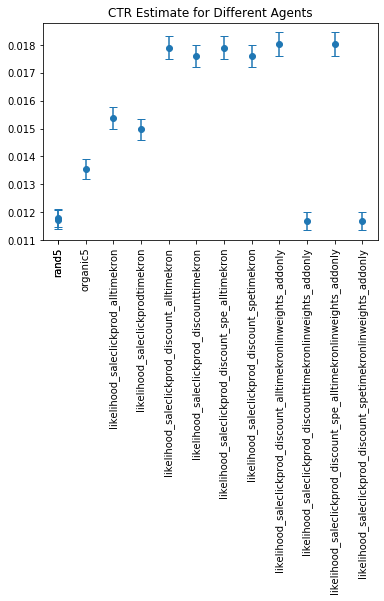

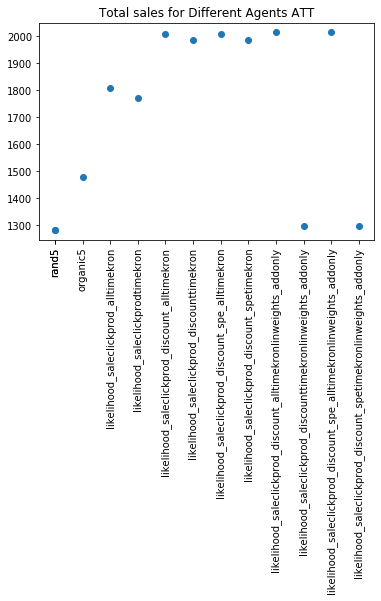

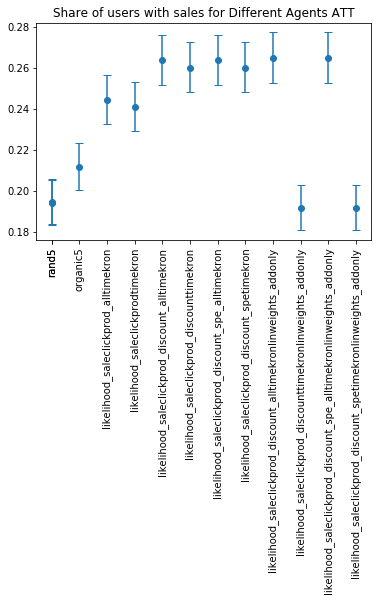

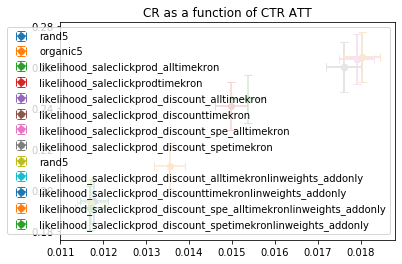

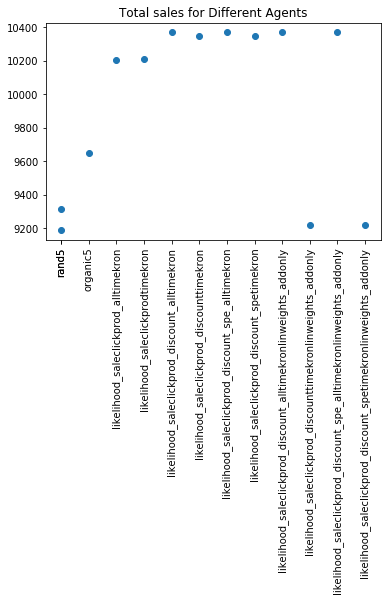

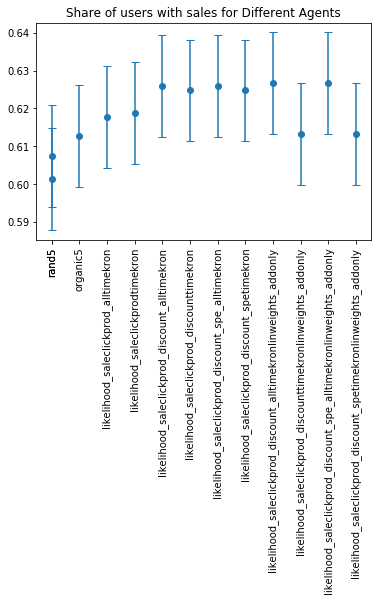

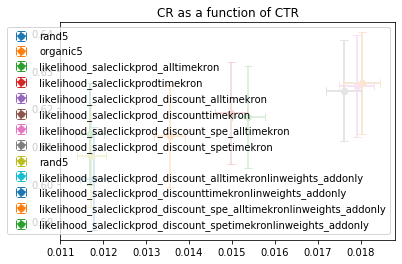

In [44]:
res = res_weights
plot_verify_agents_sale(res["CTR"], res["Tot sales ATT"], res['Share user with sale ATT'], 
                        res["Tot sales"], res['Share user with sale'])
None

In [45]:
display(res["CTR"])
display(res["Tot sales ATT"])
display(res['Share user with sale ATT'])
display(res["Tot sales"])
display(res['Share user with sale'])

,Agent,0.025,0.500,0.975
0,rand5,0.011460,0.011791,0.012129
1,organic5,0.013190,0.013547,0.013909
2,likelihood_saleclickprod_alltimekron,0.015002,0.015381,0.015767
3,likelihood_saleclickprodtimekron,0.014601,0.014974,0.015353
4,likelihood_saleclickprod_discount_alltimekron,0.017496,0.017905,0.018320
5,likelihood_saleclickprod_discounttimekron,0.017199,0.017604,0.018016
6,likelihood_saleclickprod_discount_spe_alltimekron,0.017496,0.017905,0.018320
7,likelihood_saleclickprod_discount_spetimekron,0.017199,0.017604,0.018016
0,rand5,0.011397,0.011728,0.012067
1,likelihood_saleclickprod_discount_alltimekronl...,0.017622,0.018033,0.018450


,Agent,TotSalesAtt
0,rand5,1282
1,organic5,1477
2,likelihood_saleclickprod_alltimekron,1806
3,likelihood_saleclickprodtimekron,1770
4,likelihood_saleclickprod_discount_alltimekron,2009
5,likelihood_saleclickprod_discounttimekron,1987
6,likelihood_saleclickprod_discount_spe_alltimekron,2009
7,likelihood_saleclickprod_discount_spetimekron,1987
0,rand5,1283
1,likelihood_saleclickprod_discount_alltimekronl...,2013


,Agent,0.025,0.500,0.975
0,rand5,0.183866,0.194681,0.205809
1,organic5,0.200505,0.211677,0.223144
2,likelihood_saleclickprod_alltimekron,0.232690,0.244468,0.256508
3,likelihood_saleclickprodtimekron,0.229349,0.241069,0.253054
4,likelihood_saleclickprod_discount_alltimekron,0.251772,0.263863,0.276196
5,likelihood_saleclickprod_discounttimekron,0.248032,0.260064,0.272342
6,likelihood_saleclickprod_discount_spe_alltimekron,0.251772,0.263863,0.276196
7,likelihood_saleclickprod_discount_spetimekron,0.248032,0.260064,0.272342
0,rand5,0.183279,0.194082,0.205197
1,likelihood_saleclickprod_discount_alltimekronl...,0.252756,0.264863,0.277210


,Agent,TotSales
0,rand5,9188
1,organic5,9648
2,likelihood_saleclickprod_alltimekron,10206
3,likelihood_saleclickprodtimekron,10212
4,likelihood_saleclickprod_discount_alltimekron,10368
5,likelihood_saleclickprod_discounttimekron,10345
6,likelihood_saleclickprod_discount_spe_alltimekron,10368
7,likelihood_saleclickprod_discount_spetimekron,10345
0,rand5,9315
1,likelihood_saleclickprod_discount_alltimekronl...,10368


,Agent,0.025,0.500,0.975
0,rand5,0.587754,0.601373,0.614888
1,organic5,0.599215,0.612770,0.626210
2,likelihood_saleclickprod_alltimekron,0.604244,0.617769,0.631173
3,likelihood_saleclickprodtimekron,0.605250,0.618768,0.632165
4,likelihood_saleclickprod_discount_alltimekron,0.612494,0.625966,0.639309
5,likelihood_saleclickprod_discounttimekron,0.611287,0.624767,0.638119
6,likelihood_saleclickprod_discount_spe_alltimekron,0.612494,0.625966,0.639309
7,likelihood_saleclickprod_discount_spetimekron,0.611287,0.624767,0.638119
0,rand5,0.593785,0.607371,0.620848
1,likelihood_saleclickprod_discount_alltimekronl...,0.613300,0.626766,0.640103


In [46]:
pkl.dump(res_weights,open("data/clean/res_weights_time.pkl","wb"))